In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
%matplotlib inline

In [2]:
# https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k
fremont_bridge_bike_counts = '4xy5-26gy'
with Socrata("data.seattle.gov", os.environ['socrata_app_token']) as client:
    data = client.get(fremont_bridge_bike_counts, order='date', limit=2000)

In [3]:
df = pd.DataFrame(data)

In [4]:
df.columns

Index(['date', 'fremont_bridge_nb', 'fremont_bridge_sb'], dtype='object')

In [5]:
df['date'] = df.date.astype(np.datetime64)
df['fremont_bridge_nb'] = df.fremont_bridge_nb.astype('int32')
df['fremont_bridge_sb'] = df.fremont_bridge_sb.astype('int32')
df['hour'] = df.date.apply(lambda d: d.hour)
df['day_of_week'] = df.date.apply(lambda d: d.dayofweek)
df['day_of_year'] = df.date.apply(lambda d: d.dayofyear)

In [6]:
df.head()

,date,fremont_bridge_nb,fremont_bridge_sb,hour,day_of_week,day_of_year
0,2012-10-03 00:00:00,4,9,0,2,277
1,2012-10-03 01:00:00,4,6,1,2,277
2,2012-10-03 02:00:00,1,1,2,2,277
3,2012-10-03 03:00:00,2,3,3,2,277
4,2012-10-03 04:00:00,6,1,4,2,277


In [7]:
df.tail()

,date,fremont_bridge_nb,fremont_bridge_sb,hour,day_of_week,day_of_year
1995,2012-12-25 03:00:00,1,1,3,1,360
1996,2012-12-25 04:00:00,1,0,4,1,360
1997,2012-12-25 05:00:00,1,0,5,1,360
1998,2012-12-25 06:00:00,2,1,6,1,360
1999,2012-12-25 07:00:00,2,2,7,1,360


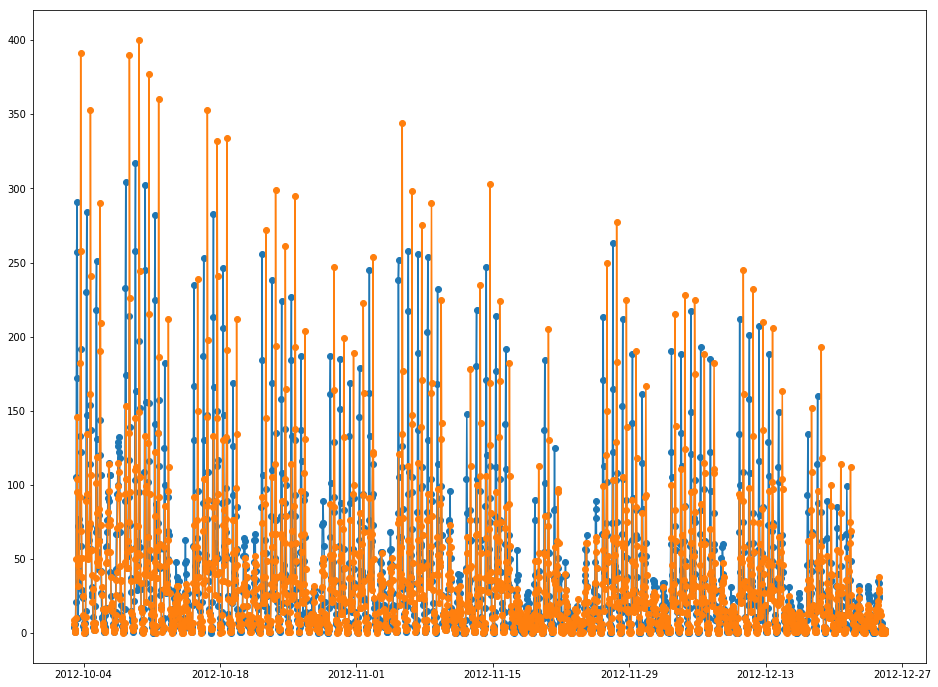

In [8]:
plt.figure(figsize=(16, 12))
plt.plot_date(df.date, df.fremont_bridge_nb, ls='solid')
plt.plot_date(df.date, df.fremont_bridge_sb, ls='solid');

In [9]:
d = df.date.iloc[121]
d.hour

1

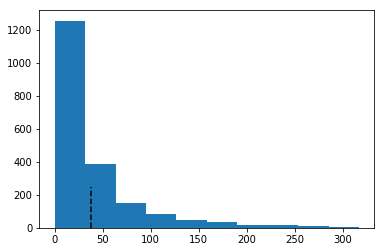

In [10]:
plt.hist(df.fremont_bridge_nb)
plt.vlines(df.fremont_bridge_nb.mean(), 0, 250, linestyles='dashed', colors='black');

In [11]:
import torch
import pyro
from pyro.distributions import Categorical, Poisson, Normal

In [12]:
rates_cache = {}
def get_rates(dow, h):
    rate_key = (int(dow), int(h))
    if rate_key in rates_cache:
        return rates_cache[rate_key]()
    matching_rows = df[(df.day_of_week == dow) & (df.hour == h)]
    avg_nb = matching_rows.fremont_bridge_nb.mean()
    std_nb = matching_rows.fremont_bridge_nb.std()
    avg_sb = matching_rows.fremont_bridge_sb.mean()
    std_sb = matching_rows.fremont_bridge_sb.std()
    def sample_rates():
        nb_rate = pyro.sample('nb_rate', Normal(avg_nb, std_nb))
        sb_rate = pyro.sample('sb_rate', Normal(avg_sb, std_sb))
        return (nb_rate, sb_rate)
    rates_cache[rate_key] = sample_rates
    return rates_cache[rate_key]()
    
dow_dist = Categorical(torch.tensor([1/7 for _ in range(7)]))
h_dist = Categorical(torch.tensor([1/24 for _ in range(24)]))
def model():
    dow = pyro.sample('day_of_week', dow_dist)
    h = pyro.sample('hour', h_dist)
    nb_rate, sb_rate = get_rates(dow, h)
    fremont_bridge_nb = pyro.sample('fremont_bridge_nb', Poisson(max(0.00001, nb_rate)))
    fremont_bridge_sb = pyro.sample('fremont_bridge_sb', Poisson(max(0.00001, sb_rate)))

In [13]:
posterior = pyro.infer.Importance(model, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites='fremont_bridge_nb')
samples = marginal((len(df),))
torch.mean(samples)

tensor(36.4490)

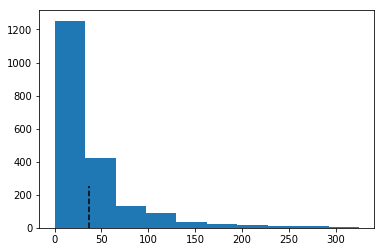

In [14]:
plt.hist(samples)
plt.vlines(torch.mean(samples), 0, 250, linestyles='dashed', colors='black');

In [15]:
conditioned_model = pyro.condition(model, data={'fremont_bridge_sb': torch.tensor(10.)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites=['day_of_week', 'hour'])
samples = marginal((1000,))

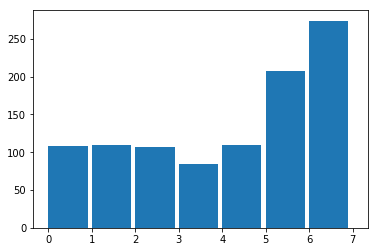

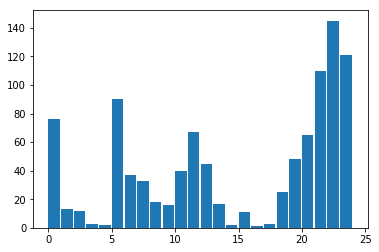

In [16]:
days = samples[:, 0]
hours = samples[:, 1]

plt.hist(days, bins=list(range(8)), width=0.9)
plt.figure()
plt.hist(hours, bins=list(range(25)), width=0.9);